In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query1 = '''select distinct f.film_id, f.title, r.rental_date,
f.rental_rate, r.return_date, i.inventory_id, f.length,
case
when(sum(case when date_format((r.rental_date), "%%M") = "May"
and date_format((r.rental_date), "%%Y") = 2005
then True else False
end )) >= 1 then 1 else 0 end as rented_in_may_2005
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title;'''


data = pd.read_sql_query(query1, engine)
data.head()

,film_id,title,rental_date,rental_rate,return_date,inventory_id,length,rented_in_may_2005
0,1,ACADEMY DINOSAUR,2005-07-08 19:03:15,0.99,2005-07-11 21:29:15,1,86,1
1,2,ACE GOLDFINGER,2005-08-01 04:24:47,4.99,2005-08-04 05:36:47,9,48,0
2,3,ADAPTATION HOLES,2005-07-27 01:21:19,2.99,2005-07-29 20:33:19,12,50,1
3,4,AFFAIR PREJUDICE,2005-07-12 02:40:41,2.99,2005-07-16 04:56:41,16,117,1
4,5,AFRICAN EGG,2005-05-28 07:53:38,2.99,2005-06-04 12:45:38,23,130,1


In [3]:
data.shape

(958, 8)

In [34]:
query2 = '''select distinct f.title,
case
when(sum(case when date_format((r.rental_date), "%%M") = "May"
and date_format((r.rental_date), "%%Y") = 2005
then True else False
end )) >= 1 then 1 else 0 end as rented_in_may_2005
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title;'''


data2 = pd.read_sql_query(query2, engine)
data2.head()


,title,rented_in_may_2005
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


In [5]:
data2.shape

(958, 2)

In [6]:
data.dtypes

film_id                        int64
title                         object
rental_date           datetime64[ns]
rental_rate                  float64
return_date           datetime64[ns]
inventory_id                   int64
length                         int64
rented_in_may_2005             int64
dtype: object

In [7]:
data.isna().sum()

film_id               0
title                 0
rental_date           0
rental_rate           0
return_date           0
inventory_id          0
length                0
rented_in_may_2005    0
dtype: int64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

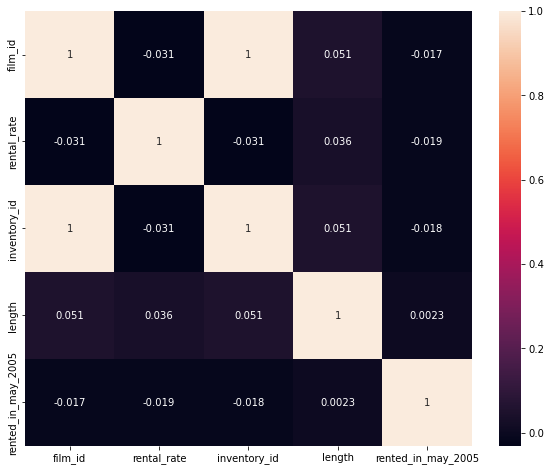

In [9]:
corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

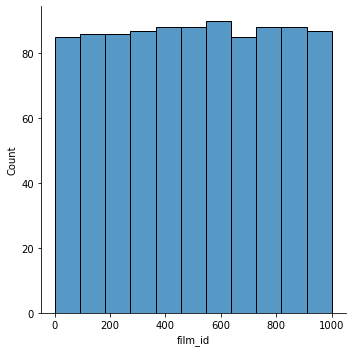

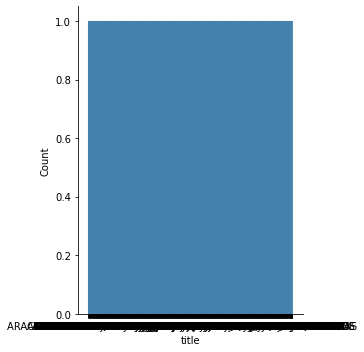

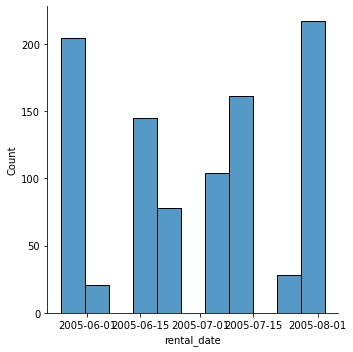

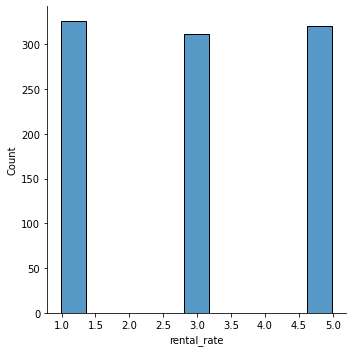

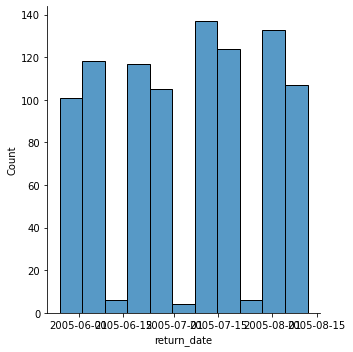

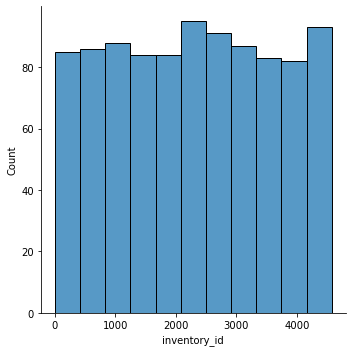

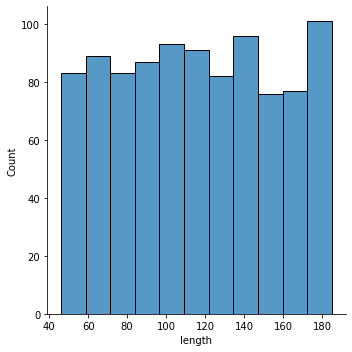

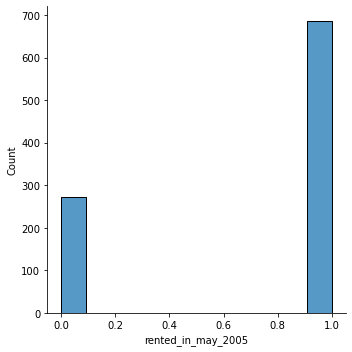

In [35]:
for i in data.columns:
    sns.displot(data[i])
    plt.show()

In [10]:
# Encode some categorical variables, or Scale numerical variables.

In [11]:
y = data['rented_in_may_2005']
X = data.drop('rented_in_may_2005', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)


In [13]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,film_id,rental_rate,inventory_id,length
0,0.075150,0.0,0.074650,0.410072
1,0.109218,0.0,0.107706,0.050360
2,0.541082,0.5,0.540499,0.201439
3,0.128257,0.5,0.128503,0.956835
4,0.141283,0.0,0.142951,0.546763


In [14]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_norm, y_train)

In [15]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [30]:
predictions = classification.predict(X_test_norm)
predictions
classification.score(X_test_norm, y_test)

/Users/esraaahmed/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/esraaahmed/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.734375

In [17]:
# 6. Evaluate the results.

In [32]:
query3 = '''
select distinct f.film_id, f.title, r.rental_date,
f.rental_rate, r.return_date, i.inventory_id, f.length,
case when
(
sum(
case
when date_format((r.rental_date), "%%M") = "June" and
date_format((r.rental_date), "%%Y") = 2005 then True
else False
end
)
) >= 1 then 1 else 0 end as rented_in_june_2005
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
where date_format((r.rental_date), "%%M") = "June"
and date_format((r.rental_date), "%%Y") = 2005
group by f.title order by r.rental_date desc;
'''

data3 = pd.read_sql_query(query3, engine)
data3.head()

,film_id,title,rental_date,rental_rate,return_date,inventory_id,length,rented_in_june_2005
0,891,TIMBERLAND SKY,2005-06-21 22:48:59,0.99,2005-06-28 19:32:59,4087,69,1
1,326,FLYING HOOK,2005-06-21 22:10:01,2.99,2005-06-30 21:35:01,1488,69,1
2,119,CAPER MOTIONS,2005-06-21 21:52:52,0.99,2005-06-28 21:41:52,547,176,1
3,383,GROOVE FICTION,2005-06-21 21:46:56,0.99,2005-06-29 20:08:56,1765,111,1
4,194,CROW GREASE,2005-06-21 21:42:33,0.99,2005-06-30 19:54:33,883,104,1


In [19]:
data3.shape

(900, 8)

In [20]:
y2 = data3['rented_in_june_2005']
X2 = data3.drop('rented_in_june_2005', axis=1)

In [21]:
X2_test_num = X2.select_dtypes(include = np.number)

# Scaling data
X2_test_normalized = transformer.transform(X2_test_num)
X2_test_norm = pd.DataFrame(X2_test_normalized)

In [28]:
predictions2 = classification.predict(X2_test_norm)
predictions2
classification.score(X2_test_norm, y2)

/Users/esraaahmed/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/esraaahmed/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1.0